## Exploração Inicial dos Dados

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import dash
from dash import dcc, html
from dash.dependencies import Input, Output
import warnings
warnings.filterwarnings("ignore")

#Carregando os dados
df = pd.read_csv('dados/world_tourism_economy_data.csv')

#Visualização inicial
print("Primeiras linhas do dataset:")
print(df.head())
print("\nInformações sobre o dataset:")
print(df.info())
print("\nEstatísticas descritivas:")
print(df.describe())

#Verificando se contém valores nulos
print("\nValores nulos por coluna:")
print(df.isnull().sum())

#Verificando se há dados duplicados
print("\nNúmero de linhas duplicadas:", df.duplicated().sum())

Primeiras linhas do dataset:
                       country country_code  year  tourism_receipts  \
0                        Aruba          ABW  1999      7.820000e+08   
1  Africa Eastern and Southern          AFE  1999      8.034209e+09   
2                  Afghanistan          AFG  1999               NaN   
3   Africa Western and Central          AFW  1999      1.443613e+09   
4                       Angola          AGO  1999      3.100000e+07   

   tourism_arrivals  tourism_exports  tourism_departures  \
0      9.720000e+05        62.542949                 NaN   
1      1.530938e+07        12.204030                 NaN   
2               NaN              NaN                 NaN   
3      3.897975e+06         3.974476                 NaN   
4      4.500000e+04         0.583858                 NaN   

   tourism_expenditures           gdp   inflation  unemployment  
0              9.495387  1.722905e+09    2.280372           NaN  
1              7.760536  2.654293e+11    7.819865  

### Limpeza e Preparação dos Dados

In [3]:
#Tratando os dados que contém valores nulos
#Para dados com valores numéricos, vou preencher com a mediana do país/ano 
numeric_cols = ['tourism_receipts', 'tourism_arrivals', 'tourism_exports', 
                'tourism_departures', 'tourism_expenditures', 'gdp', 
                'inflation', 'unemployment']

for col in numeric_cols:
    df[col] = df.groupby(['country', 'year'])[col].transform(
        lambda x: x.fillna(x.median()))
    
#Se ainda conter nulos, irei preencher com a mediana global/ano
for col in numeric_cols:
    df[col] = df.groupby('year')[col].transform(
        lambda x: x.fillna(x.median()))

#Criando as novas features
df['tourism_balance'] = df['tourism_receipts'] - df['tourism_expenditures']
df['tourism_intensity'] = df['tourism_receipts'] / df['gdp']
df['arrivals_per_capita'] = df['tourism_arrivals'] / (df['gdp'] / df['gdp'].mean())  # Aproximação

#Verificando o resultado após os tratamentos que fiz
print("\nValores nulos após tratamento:")
print(df.isnull().sum())


Valores nulos após tratamento:
country                   0
country_code              0
year                      0
tourism_receipts        798
tourism_arrivals        798
tourism_exports         798
tourism_departures      798
tourism_expenditures    798
gdp                       0
inflation                 0
unemployment              0
tourism_balance         798
tourism_intensity       798
arrivals_per_capita     798
dtype: int64


### Análise Exploratória

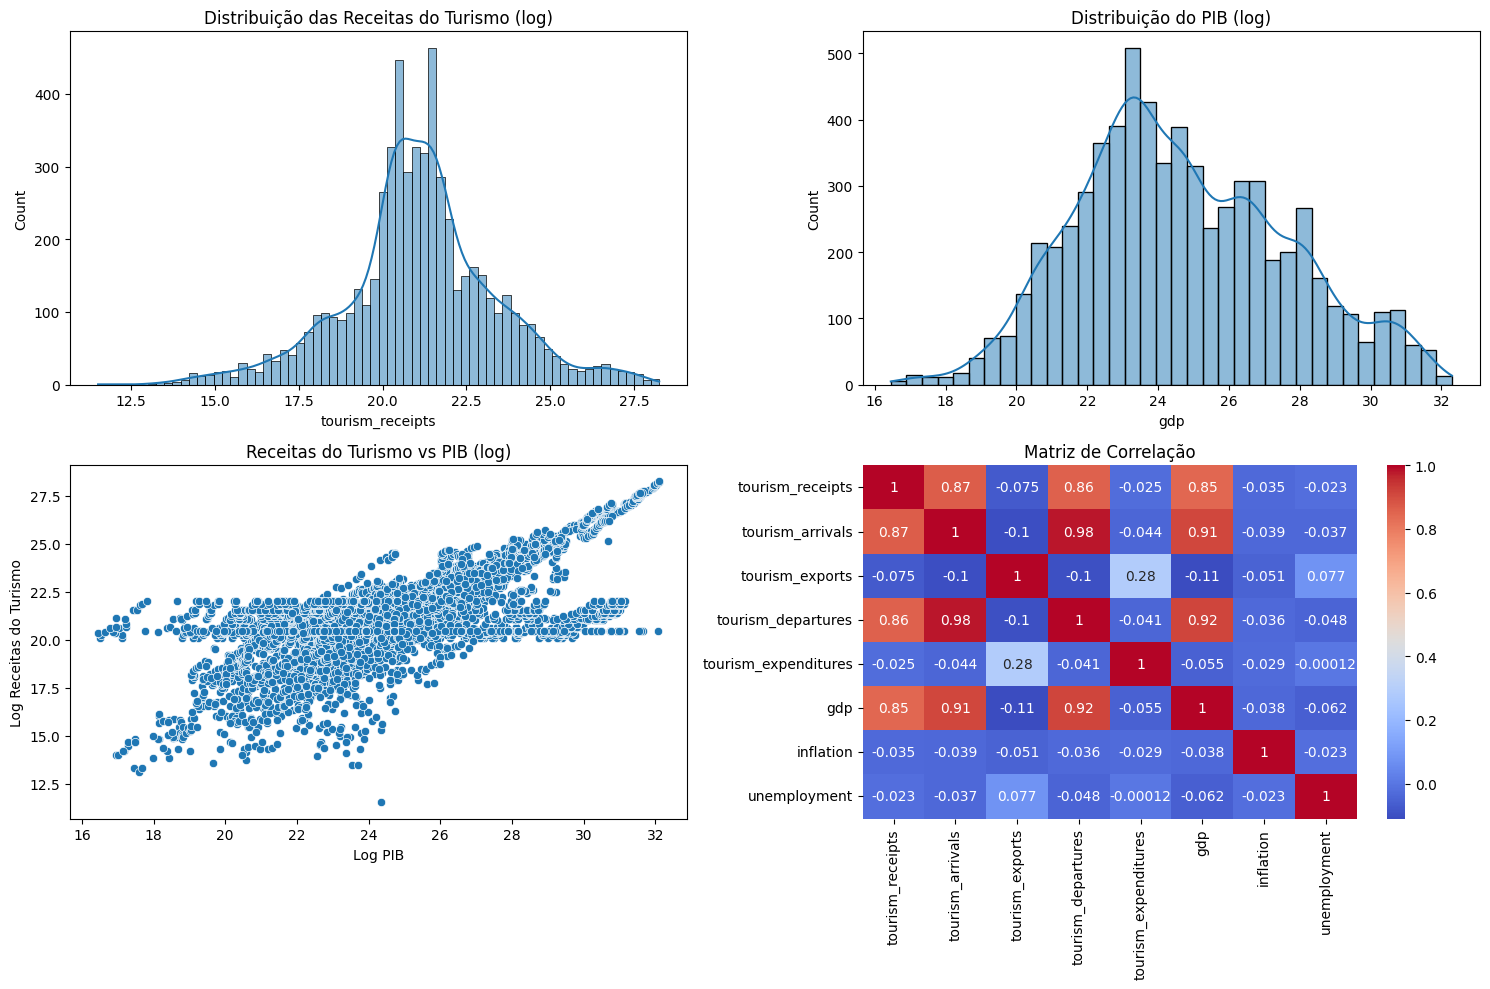

In [4]:
#Configurando os gráficos
plt.figure(figsize=(15, 10))

#Distribuição das receitas do turismo
plt.subplot(2, 2, 1)
sns.histplot(np.log1p(df['tourism_receipts']), kde=True)
plt.title('Distribuição das Receitas do Turismo (log)')

#Distribuição do PIB
plt.subplot(2, 2, 2)
sns.histplot(np.log1p(df['gdp']), kde=True)
plt.title('Distribuição do PIB (log)')

#Relação entre receitas do turismo e PIB
plt.subplot(2, 2, 3)
sns.scatterplot(x=np.log1p(df['gdp']), y=np.log1p(df['tourism_receipts']))
plt.title('Receitas do Turismo vs PIB (log)')
plt.xlabel('Log PIB')
plt.ylabel('Log Receitas do Turismo')

#Correlação entre variáveis do tipo numérico
plt.subplot(2, 2, 4)
corr_matrix = df[numeric_cols].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Matriz de Correlação')

plt.tight_layout()
plt.show()

### Análise Temporal

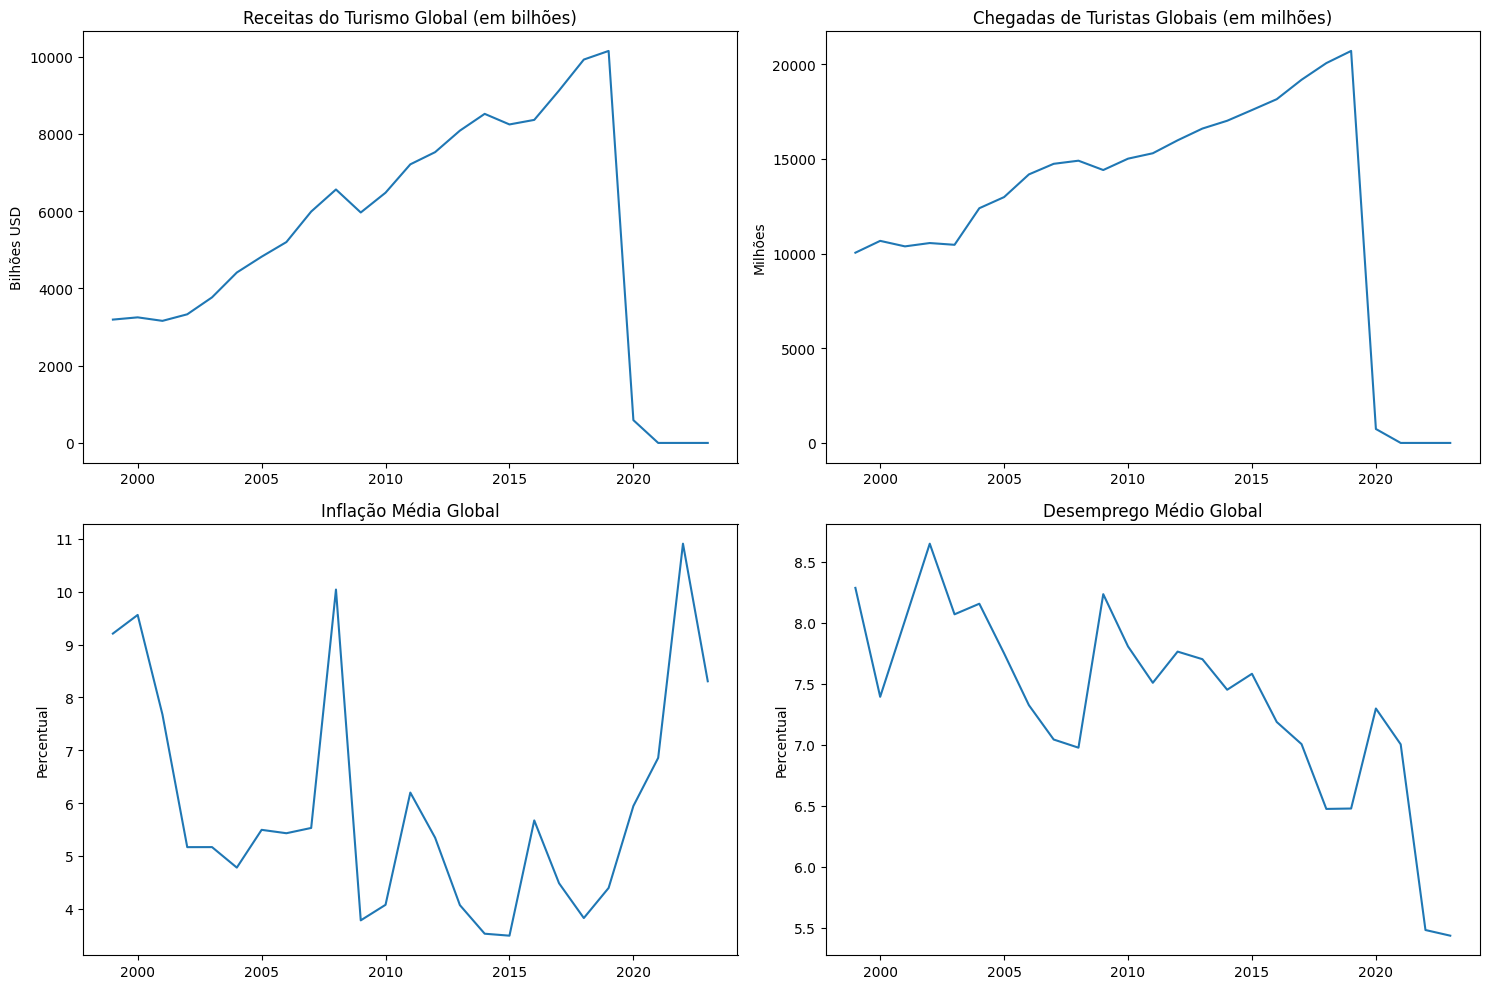

In [5]:
    #Agregando os dados por ano
annual_data = df.groupby('year').agg({
    'tourism_receipts': 'sum',
    'tourism_arrivals': 'sum',
    'gdp': 'sum',
    'inflation': 'mean',
    'unemployment': 'mean'
}).reset_index()

#Visualizando as tendências
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

#Receitas do turismo
axes[0, 0].plot(annual_data['year'], annual_data['tourism_receipts']/1e9)
axes[0, 0].set_title('Receitas do Turismo Global (em bilhões)')
axes[0, 0].set_ylabel('Bilhões USD')

#Chegadas de turistas
axes[0, 1].plot(annual_data['year'], annual_data['tourism_arrivals']/1e6)
axes[0, 1].set_title('Chegadas de Turistas Globais (em milhões)')
axes[0, 1].set_ylabel('Milhões')

#Inflação média
axes[1, 0].plot(annual_data['year'], annual_data['inflation'])
axes[1, 0].set_title('Inflação Média Global')
axes[1, 0].set_ylabel('Percentual')

#Desemprego médio
axes[1, 1].plot(annual_data['year'], annual_data['unemployment'])
axes[1, 1].set_title('Desemprego Médio Global')
axes[1, 1].set_ylabel('Percentual')

plt.tight_layout()
plt.show()

### Clusterização dos Dados

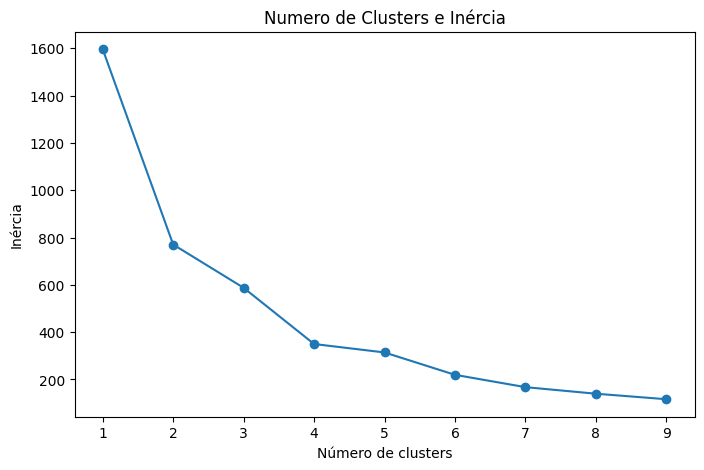


Características dos clusters:
         tourism_receipts  tourism_arrivals  tourism_expenditures  \
cluster                                                             
0            5.676193e+09      2.616013e+07              6.206925   
1            3.958012e+11      9.026770e+08              7.101055   
2            1.887560e+09      3.279300e+06             13.759550   
3            7.235000e+08      9.469000e+05             13.890501   

         tourism_balance  tourism_intensity           gdp  
cluster                                                    
0           5.676193e+09           0.197252  5.366186e+11  
1           3.958012e+11           0.015798  2.620748e+13  
2           1.887560e+09           0.190546  1.512206e+11  
3           7.235000e+08          38.690093  1.893005e+07  


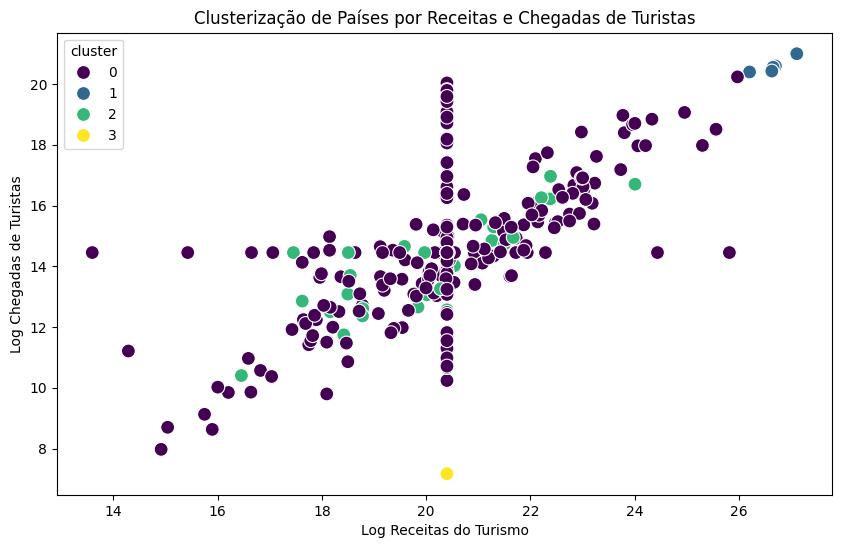

In [6]:
#Preparando os dados para começar a clusterização
cluster_data = df[df['year'] == 2002][['tourism_receipts', 'tourism_arrivals', 
                                      'tourism_expenditures', 'tourism_balance',
                                      'tourism_intensity', 'gdp']].dropna()

#Normalizando os dados
scaler = StandardScaler()
cluster_data_scaled = scaler.fit_transform(cluster_data)

#Determinando o número de clusters
inertia = []
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(cluster_data_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(range(1, 10), inertia, marker='o')
plt.title('Numero de Clusters e Inércia')
plt.xlabel('Número de clusters')
plt.ylabel('Inércia')
plt.show()

#Aplicando o método K-means com k=4
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(cluster_data_scaled)
cluster_data['cluster'] = clusters

#Analisando os clusters
cluster_analysis = cluster_data.groupby('cluster').mean()
print("\nCaracterísticas dos clusters:")
print(cluster_analysis)

#Visualizando os clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x=np.log1p(cluster_data['tourism_receipts']), 
                y=np.log1p(cluster_data['tourism_arrivals']), 
                hue=cluster_data['cluster'], palette='viridis', s=100)
plt.title('Clusterização de Países por Receitas e Chegadas de Turistas')
plt.xlabel('Log Receitas do Turismo')
plt.ylabel('Log Chegadas de Turistas')
plt.show()

In [7]:
#Análise de concentração do mercado de acordo com o ano escolhido
top10_2002 = df[df['year'] == 2002].nlargest(10, 'tourism_receipts')
market_share = top10_2002['tourism_receipts'].sum() / df[df['year'] == 2002]['tourism_receipts'].sum()

print(f"Top 10 destinos concentram {market_share:.1%} das receitas globais em 2002")

Top 10 destinos concentram 78.9% das receitas globais em 2002


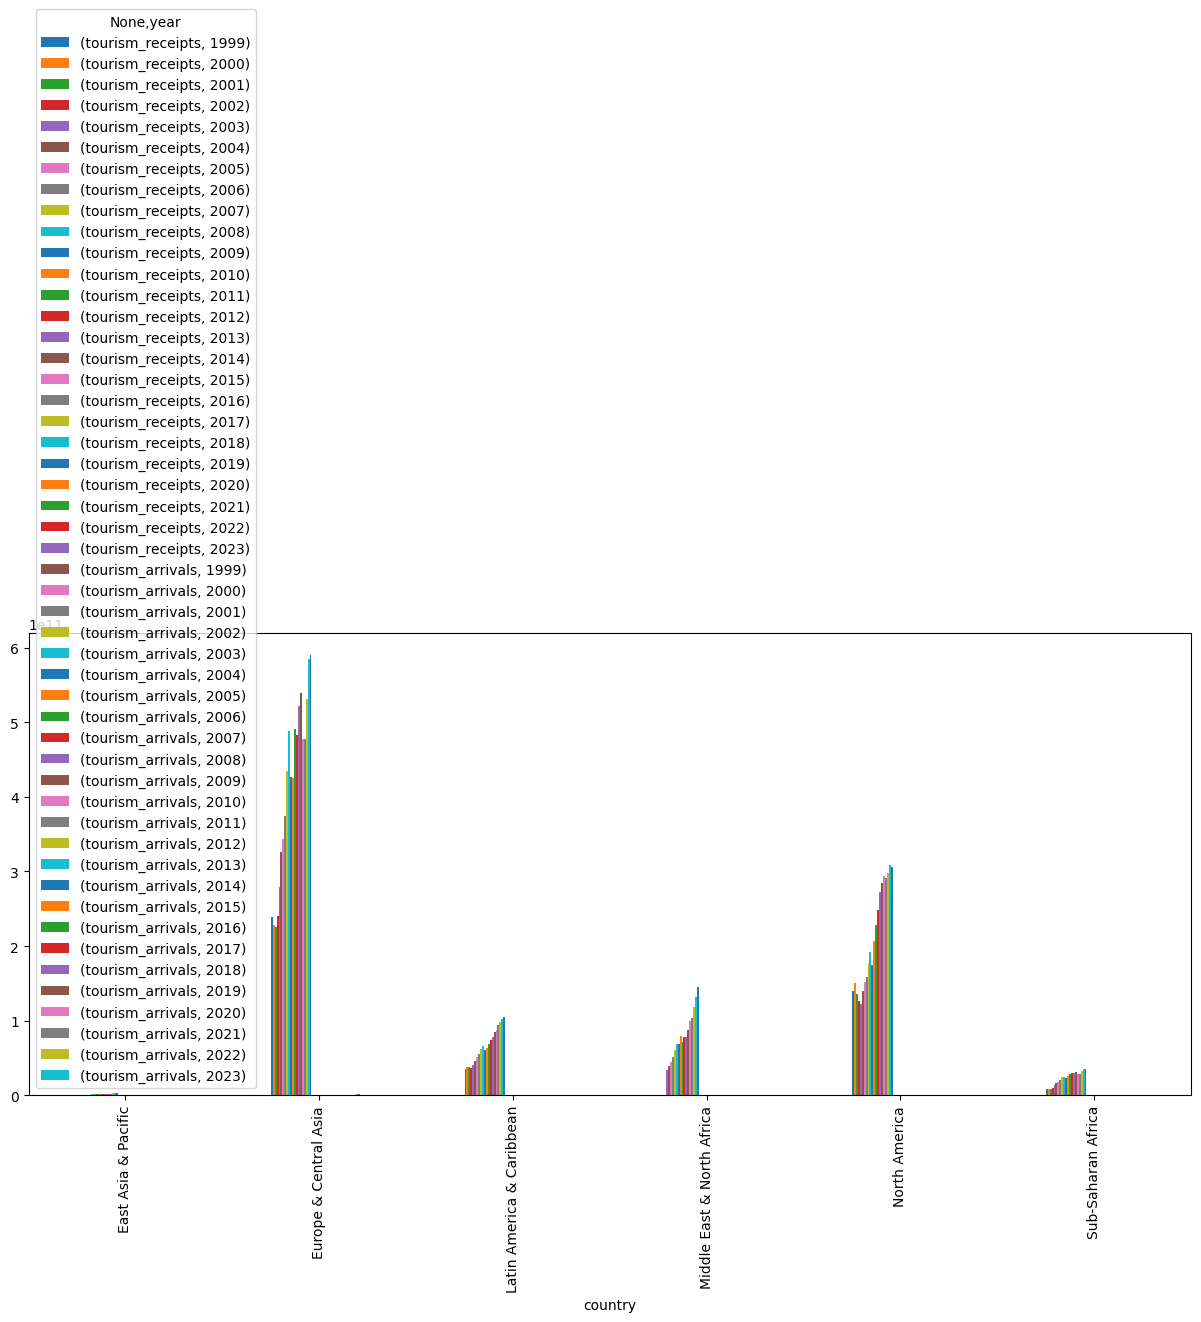

In [9]:
#Agregando por regiões escolhidas
regions = ['Europe & Central Asia', 'North America', 'East Asia & Pacific', 
           'Latin America & Caribbean', 'Middle East & North Africa', 'Sub-Saharan Africa']

regional_data = df[df['country'].isin(regions)].groupby(['country', 'year']).agg({
    'tourism_receipts': 'sum',
    'tourism_arrivals': 'sum'
}).unstack().plot(kind='bar', figsize=(15,6))

### Criação do Dashboard com a Biblioteca Dash

In [10]:
#Criando o aplicativo Dash
app = dash.Dash(__name__)

#Layout do dashboard
#No título coloquei aqua, se o tema for dark ou light vai dar pra visualizar da mesma forma.
app.layout = html.Div([
    html.H1("Análise do Turismo Mundial (1999-2002)", style={'textAlign': 'center', 'color': 'aqua'}),
    
    html.Div([
        dcc.Dropdown(
            id='year-selector',
            options=[{'label': str(year), 'value': year} for year in df['year'].unique()],
            value=2002,
            style={'width': '50%'}
        )
    ], style={'padding': '20px'}),
    
    html.Div([
        dcc.Graph(id='receipts-map'),
        dcc.Graph(id='arrivals-scatter')
    ], style={'display': 'flex'}),
    
    html.Div([
        dcc.Graph(id='top-countries'),
        dcc.Graph(id='cluster-analysis')
    ], style={'display': 'flex'}),
    
    html.Div([
        dcc.Graph(id='time-series')
    ])
])

#Callbacks para filtros
@app.callback(
    [Output('receipts-map', 'figure'),
     Output('arrivals-scatter', 'figure'),
     Output('top-countries', 'figure'),
     Output('cluster-analysis', 'figure'),
     Output('time-series', 'figure')],
    [Input('year-selector', 'value')]
)
def update_dashboard(selected_year):
    #Filtrando os dados pelo ano selecionado
    year_data = df[df['year'] == selected_year]
    
    #Mapa de receitas do turismo
    receipts_map = px.choropleth(
        year_data,
        locations="country_code",
        color="tourism_receipts",
        hover_name="country",
        color_continuous_scale=px.colors.sequential.Plasma,
        title=f"Receitas do Turismo por País ({selected_year})"
    )
    
    #Dispersão: Receitas vs Chegadas
    arrivals_scatter = px.scatter(
        year_data,
        x="tourism_arrivals",
        y="tourism_receipts",
        size="gdp",
        color="tourism_balance",
        hover_name="country",
        log_x=True,
        log_y=True,
        title=f"Receitas vs Chegadas de Turistas ({selected_year})"
    )
    
    #Top 10 países por receitas
    top_countries = year_data.nlargest(10, 'tourism_receipts')
    top_chart = px.bar(
        top_countries,
        x="country",
        y="tourism_receipts",
        color="tourism_intensity",
        title=f"Top 10 Países por Receitas do Turismo ({selected_year})"
    )
    
    #Análise dos clusters
    cluster_fig = px.scatter(
        cluster_data,
        x="tourism_receipts",
        y="tourism_arrivals",
        color="cluster",
        size="gdp",
        hover_name=df[df['year'] == selected_year]['country'],
        log_x=True,
        log_y=True,
        title="Clusterização de Países por Perfil Turístico"
    )
    
    #Série temporal
    time_series = make_subplots(specs=[[{"secondary_y": True}]])
    time_series.add_trace(
        go.Scatter(x=annual_data['year'], y=annual_data['tourism_receipts']/1e9, name="Receitas (bilhões)"),
        secondary_y=False
    )
    time_series.add_trace(
        go.Scatter(x=annual_data['year'], y=annual_data['tourism_arrivals']/1e6, name="Chegadas (milhões)"),
        secondary_y=True
    )
    time_series.update_layout(title="Tendências Globais do Turismo")
    time_series.update_yaxes(title_text="Receitas (bilhões USD)", secondary_y=False)
    time_series.update_yaxes(title_text="Chegadas (milhões)", secondary_y=True)
    
    return receipts_map, arrivals_scatter, top_chart, cluster_fig, time_series

#Executando o dashboard no ambiente do notebook python
if __name__ == '__main__':
    app.run_server(debug=True)